In [1]:
import numpy as np
import matplotlib.pyplot as plt

import uproot
import awkward as ak

import ROOT
from  ROOT import TH1D, TCanvas, TMath, TLegend

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
plt.rc("font", size=14)

In [3]:
def event_generator(N_events, xmin, xmax):

    N_sim = int(100* N_events)

    phi_uniform = np.random.uniform(xmin, xmax, N_sim)
    
    accept = 1. + np.cos(phi_uniform)* np.cos(phi_uniform)

    weights = np.random.uniform(1., 2., N_sim)

    accepted_events = np.where(accept < weights, phi_uniform, -999.)

    return accepted_events[accepted_events > -999.][:N_events]

In [4]:
def plot_hist(events, bins=20):

    phi_hist = TH1D("phi_hist", "; #phi ; counts", bins, -pi, pi)

    [phi_hist.Fill(phi) for phi in events];

    xvals = np.array([phi_hist.GetBinCenter(i+1) for i in range(bins)])
    xerror = np.array([phi_hist.GetBinWidth(i+1) for i in range(bins)])
    yvals = np.array([phi_hist.GetBinContent(i+1) for i in range(bins)])
    yerror = np.array([phi_hist.GetBinError(i+1) for i in range(bins)])

    phi_mean_original = phi_hist.GetMean()

    plt.figure(figsize=(8., 8.))
    plt.bar(xvals, yvals, width=xerror, color="limegreen", label=f"original: mean {phi_hist.GetMean():>3f}")
    plt.xlabel(r"$\phi$")
    plt.ylabel("counts")
    plt.legend(frameon=False)
    plt.show()

    del phi_hist

    return phi_mean_original

In [5]:
def plot_two_hist(original, resampled, bins=20):

    phi_original = TH1D("phi_original", "; #phi ; counts", bins, -pi, pi)
    phi_resampled = TH1D("phi_resampled", "; #phi ; counts", bins, -pi, pi)

    [phi_original.Fill(phi) for phi in original];
    [phi_resampled.Fill(phi) for phi in resampled];

    xvals1 = np.array([phi_original.GetBinCenter(i+1) for i in range(bins)])
    xerror1 = np.array([phi_original.GetBinWidth(i+1) for i in range(bins)])
    yvals1 = np.array([phi_original.GetBinContent(i+1) for i in range(bins)])
    yerror1 = np.array([phi_original.GetBinError(i+1) for i in range(bins)])

    xvals2 = np.array([phi_resampled.GetBinCenter(i+1) for i in range(bins)])
    xerror2 = np.array([phi_resampled.GetBinWidth(i+1) for i in range(bins)])
    yvals2 = np.array([phi_resampled.GetBinContent(i+1) for i in range(bins)])
    yerror2 = np.array([phi_resampled.GetBinError(i+1) for i in range(bins)])

    plt.figure(figsize=(8., 8.))
    plt.bar(xvals1, yvals1, width=xerror1, color="limegreen", label=f"original: mean {phi_original.GetMean():>3f}")
    plt.errorbar(xvals2, yvals2, yerr=yerror2, xerr=xerror2/2., fmt="bo", capsize=2., label=f"resampled: mean {phi_resampled.GetMean():>3f}")
    plt.xlabel(r"$\phi$")
    plt.ylabel("counts")
    plt.legend(frameon=False)
    plt.show()

    del phi_original
    del phi_resampled

In [6]:
def phi_split_mean(events):

    bins = 20

    hist = TH1D("hist", "", bins, -pi, pi)

    [hist.Fill(phi) for phi in events];

    mean_val = hist.GetMean()

    del hist

    return mean_val

# Bootstrapping method

In this notebook, we use the bootstrapping method to calculate the error of the mean of a distribution with the form $\phi \sim 1 + \cos^{2}{\phi}$. The bootstrapping steps are given below:

1. Create a new dataset by selecting N random observations from the original data, with replacement. Some data points will be selected more than once, while others may not be selected at all. Call this new dataset $X^{\prime}$.
2. Calculate the mean of $X^{\prime}$.
3. Repeat the procedure many times.

The width of the distribution of the mean, calculated from the resampled datasets, gives you the error on the mean.

We test this approach with an alternative method explained in Section 2.

## Bootstrapping Approach

In [7]:
N_sim = 100000
pi = TMath.Pi()

bins = 20

In [8]:
phi_original = event_generator(N_sim, -pi, pi)

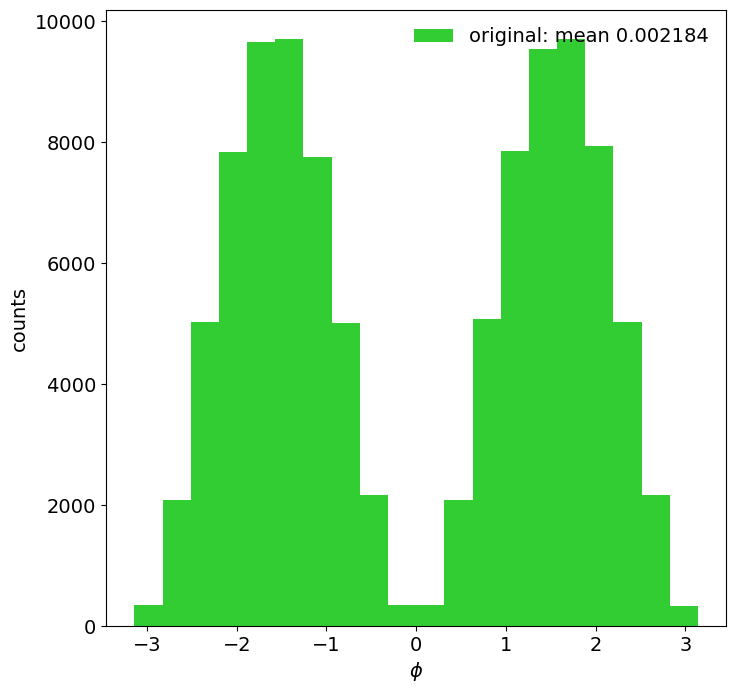

In [9]:
phi_original_mean = plot_hist(phi_original)

In [10]:
phi_resample = resample(phi_original)

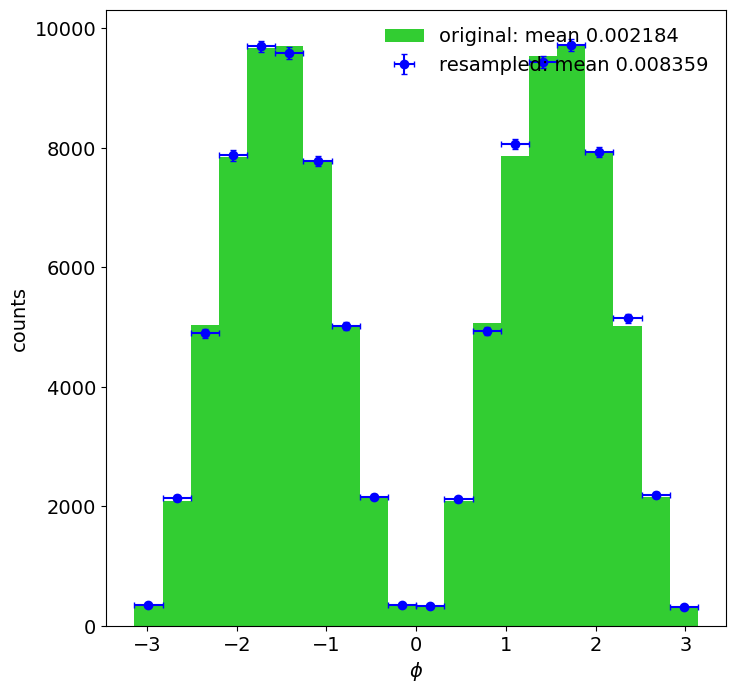

In [11]:
plot_two_hist(phi_original, phi_resample)

In [12]:
samples = 100
phi_bootstrap_mean = []


for i in range(samples):
    
    resampled_phi = resample(phi_original)
    hist = TH1D("hist", "", bins, -pi, pi)
    [hist.Fill(phi) for phi in resampled_phi];
    phi_bootstrap_mean.append(hist.GetMean())

    del hist

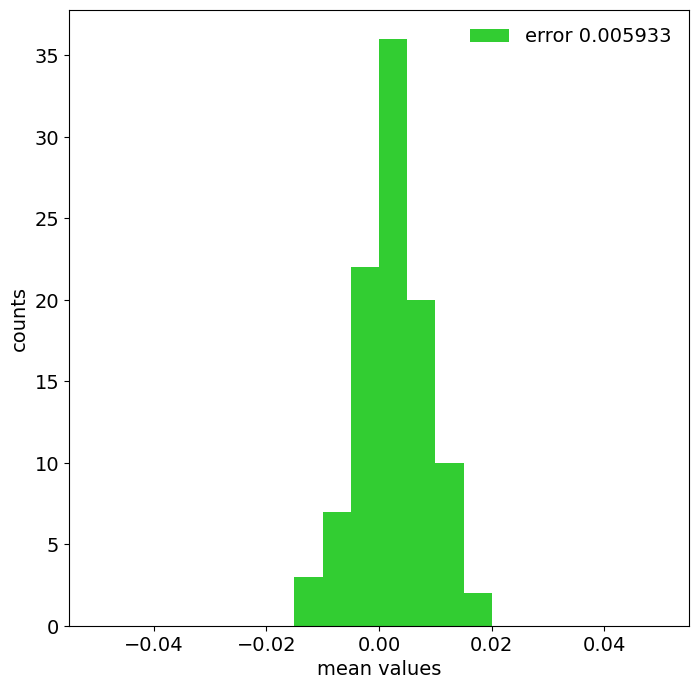

In [13]:
mean_hist = TH1D("mean_hist", "", bins, -0.05, 0.05)
[mean_hist.Fill(val) for val in phi_bootstrap_mean];
xvals = np.array([mean_hist.GetBinCenter(i+1) for i in range(bins)])
yvals = np.array([mean_hist.GetBinContent(i+1) for i in range(bins)])
xerror = np.array([mean_hist.GetBinWidth(i+1) for i in range(bins)])

plt.figure(figsize=(8, 8))
plt.bar(xvals, yvals, width=xerror, color="limegreen", label=f"error {mean_hist.GetStdDev():3f}")
plt.xlabel("mean values")
plt.ylabel("counts")
plt.legend(frameon=False)
plt.show()

del mean_hist

## Alternative Approach

In this approach, we split the data samples into $n$ independent subsets. Then, we calculate the mean of each subset, and the error is given as $\text{std(mean)} / \sqrt{n}$.

In [14]:
N_split = 10

phi_mean_split = []

kf = KFold(n_splits=N_split, shuffle=True)

for train_index, test_index in kf.split(phi_original):
    phi_mean_split.append(phi_split_mean(phi_original[test_index]))

In [15]:
yvals = ["Bootstrap", "Alternative"]
xvals = [phi_original_mean, phi_original_mean]
xerror = [np.std(phi_bootstrap_mean), np.std(phi_mean_split)/np.sqrt(N_split)]

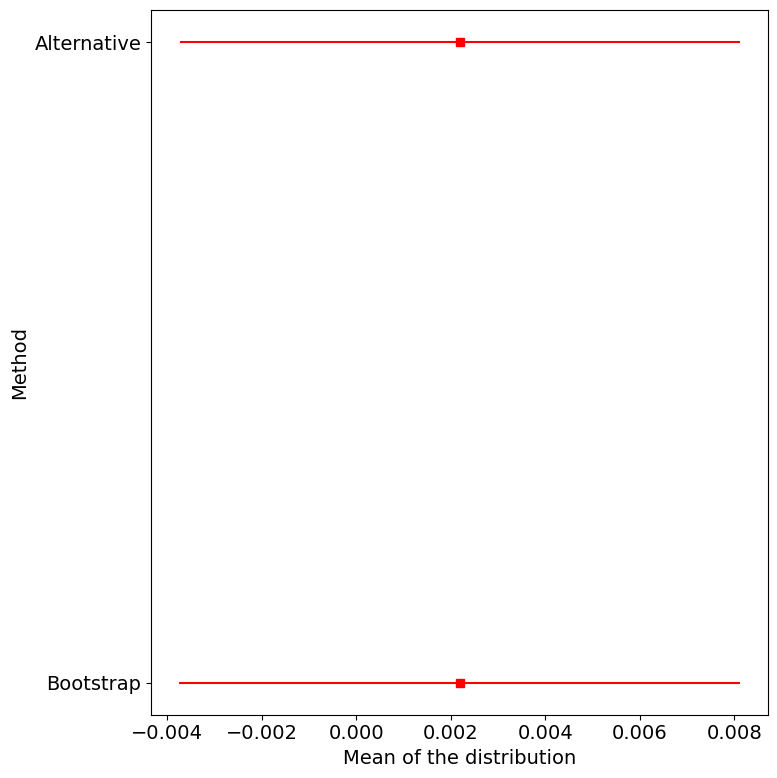

In [16]:
plt.figure(figsize=(8, 8))

plt.errorbar(xvals, yvals, xerr=xerror, fmt="rs")
plt.xlabel("Mean of the distribution")
plt.ylabel("Method")
plt.tight_layout()
plt.show()

In [17]:
print(f"===> Bootstrapping method {phi_original_mean:4f} +/- {np.std(phi_bootstrap_mean):4f}")
print(f"===> Alternative method {phi_original_mean:4f} +/- {np.std(phi_mean_split)/np.sqrt(N_split):4f}")

===> Bootstrapping method 0.002184 +/- 0.005933
===> Alternative method 0.002184 +/- 0.005926


In [19]:
print(f"==> mean of the split subsets {np.mean(phi_mean_split):4f}")

==> mean of the split subsets 0.002184


As expected, the errors calculated by both methods are very similar.